In [21]:
%matplotlib widget

In [22]:
import sys
from os import path
sys.path.append(path.abspath('') + "/../../")

In [23]:
import sifi_cm.root_aux as raux
import matplotlib.pyplot as plt
import numpy as np
import uproot
import pandas as pd
# from sifi_cm.hypmed import HypmedImporter, Reco_image, figure_layers,\
#                            get_vec_from_layers, get_map, get_hypmed_data
from sifi_cm.data_fit import smooth, normalize
import os

# Reco

In [24]:
# simdata, source = raux.get_histo("./sim220_170-det55_2p01_7lay-nowallpetcut-mask467_cut51_45-70mm_1d_phasespace0_130MeV_-20_0_nocut.root",
simdata, source = raux.get_deposits_source("./sim220_170-det55_2p01_7lay-nowallpetcut-mask467_cut51_45-70mm_1d_phasespace0_130MeV_-40_0_nocut.root")

In [25]:
simdata1 = raux.get_deposits("./sim220_170-det55_2p01_7lay-nowallpetcut-mask467_cut51_45-70mm_1d_phasespace1_130MeV_-40_0_nocut.root")
simdata += simdata1

In [26]:
simdata2 = raux.get_deposits("./sim220_170-det55_2p01_7lay-nowallpetcut-mask467_cut51_45-70mm_1d_phasespace2_130MeV_-40_0_nocut.root")
simdata += simdata2

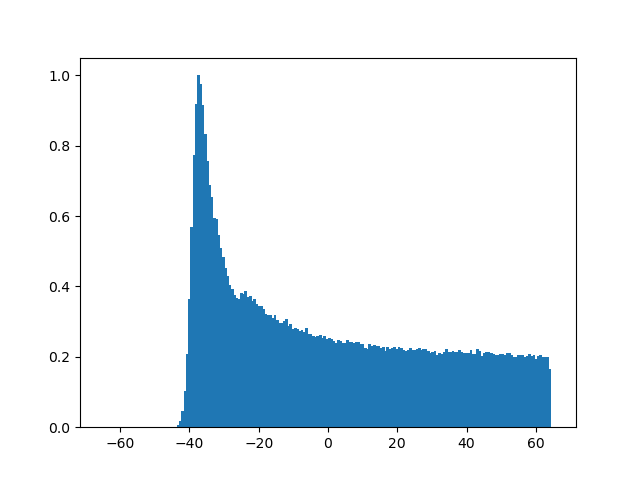

In [27]:
plt.figure()
plt.bar(source.edges.x_cent, normalize(source.vals[:,0]))
plt.show()

In [28]:
matr = raux.get_hmat("matr220_170-n1e6-det55_2p01_7lay-nowallpetcut-mask467_cut51_45-70mm_1d.root")

In [29]:
reco = raux.reco_mlem(matr, simdata.vals.flatten(), niter=5000, keep_all=True)

Reconstruction: 100%|██████████| 5000/5000 [00:00<00:00, 106201.04it/s]


In [30]:
mse = []
iuqi = []
for rec in reco:
    mse_tmp, iuqi_tmp = raux.mse_uqi(rec, source.vals[:,0], normall=True)
    mse.append(mse_tmp)
    iuqi.append(iuqi_tmp)

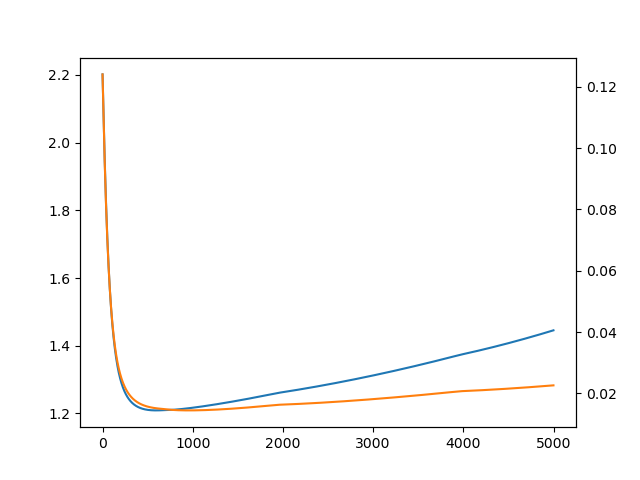

In [31]:
fig, ax = plt.subplots()

ax.plot(iuqi[1:])
ax2 = ax.twinx()
ax2.plot(mse[1:], color="tab:orange")

In [32]:
np.argmin(iuqi)

593

In [33]:
reco_sm = normalize(smooth(reco[np.argmin(iuqi)], scale=4, filter="median"))
# reco_sm = smooth(reco[800]/reco[800].max(), scale=3)

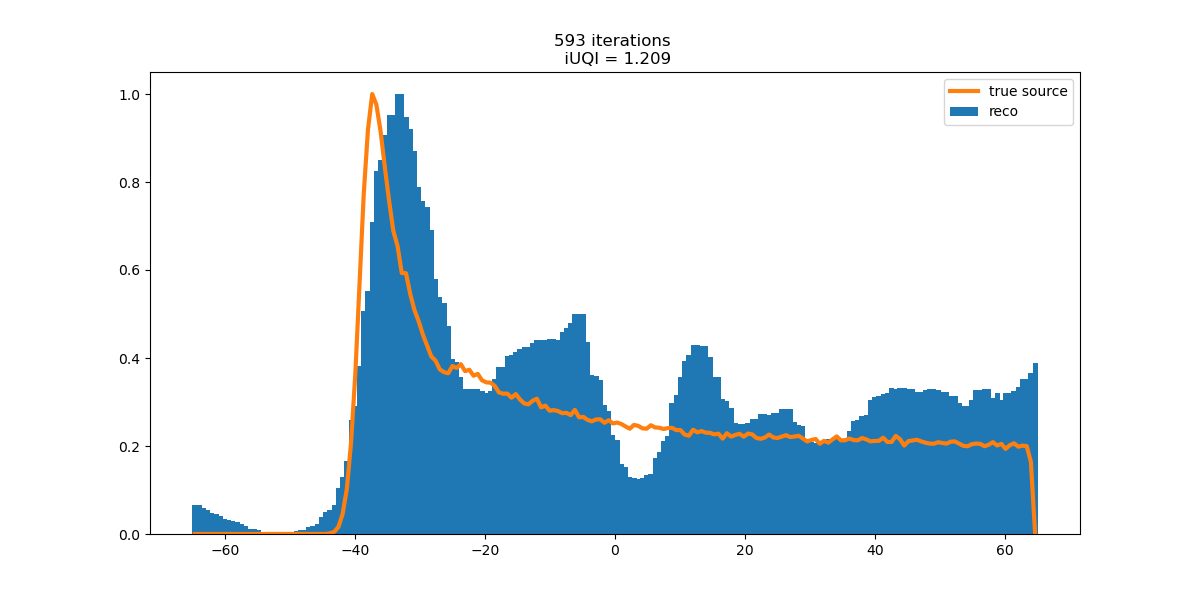

In [34]:
plt.figure(figsize=(12,6))
# plt.bar(source.edges.x_cent, reco[np.argmin(iuqi)]/reco[np.argmin(iuqi)].max(), label="reco")
plt.bar(source.edges.x_cent, reco_sm, label="reco")
plt.plot(source.edges.x_cent, source.vals[:,0]/source.vals[:,0].max(),
         c="tab:orange", label="true source", lw=3)
plt.title(f"{np.argmin(iuqi)} iterations \n iUQI = {round(iuqi[np.argmin(iuqi)], 3)}")
plt.legend()
# plt.savefig(f"figures_phasespace/reco_phasespace0_130MeV_{np.argmin(iuqi)}iter.png", facecolor="white", dpi=600)
plt.show()

# Distal faloff

In [37]:
x = source.edges.x_cent
# y = reco_sm
y = normalize(source.vals.flatten())
y_noisy = y + np.random.normal(size=y.shape, scale=0.1)

In [38]:
from sifi_cm.data_fit import DistalFalloff

In [39]:
DistalFalloff(x, y)

(-40.183254462317112853, -40.058929555535)

In [43]:
DistalFalloff(x, reco_sm)


(-39.542678315278932684, -38.97278512304249)

In [ ]:
peaks = find_peaks(reco_sm)[0]
maxpeak_index = peaks[reco_sm[peaks].argmax()]
maxpeak_x = x[maxpeak_index]
maxpeak_y = reco_sm[maxpeak_index]

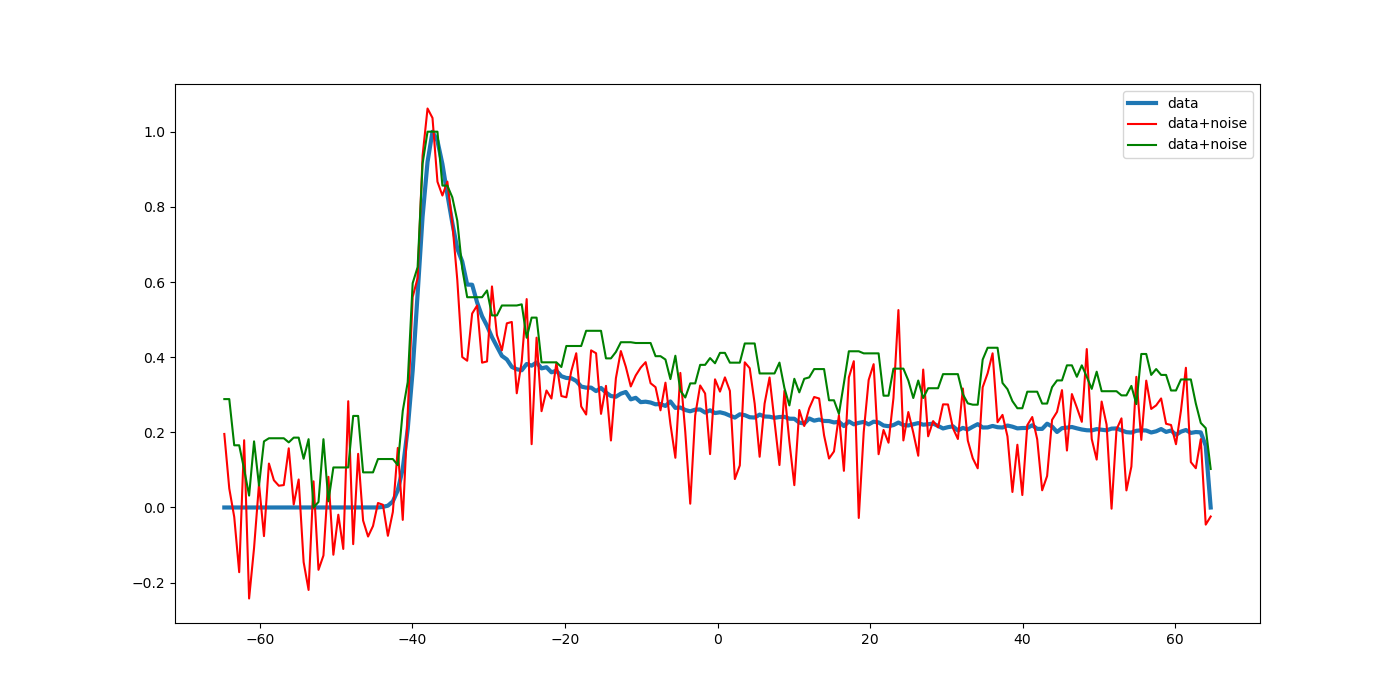

In [54]:
plt.figure(figsize=(14,7))
plt.plot(x, y, label="data", lw=3)
plt.plot(x, y_noisy, label="data+noise", c="red")
plt.plot(x, smooth(y_noisy, scale=4, filter="median"), label="data+noise", c="g")
plt.legend()
plt.show()

## Spline (true data)

from  
    Machine learning-based patient specific prompt-gamma dose monitoring in proton therapy  
    July 2013 Physics in Medicine and Biology 58(13):4563-77  
    DOI: 10.1088/0031-9155/58/13/4563  
    Gueth et al

In [ ]:
xmax = x[y.argmax()]
ymax = y.max()
ymin = y[:y.argmax()].mean()
# ymin = 0
ymin = np.median(y[:y.argmax()])
y_50proc = np.mean([ymin, ymax])

In [ ]:
f = interpolate.UnivariateSpline(x, y - y_50proc, s=0)

In [ ]:
roots = f.roots()
distal = roots[roots < x[y.argmax()]][0]
print("True distal:", round(distal, 2))

True distal: -39.53


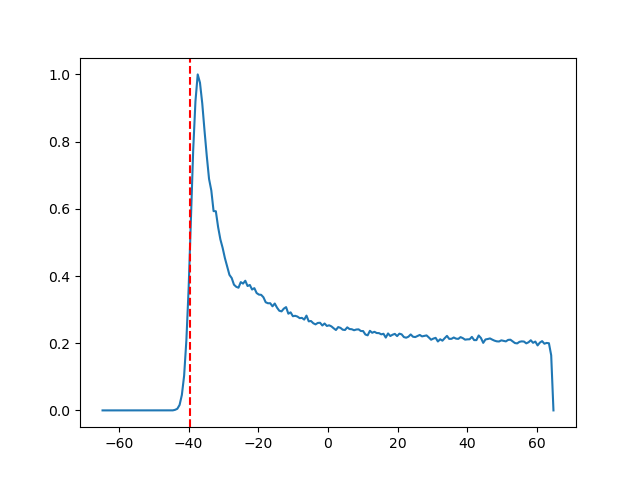

In [ ]:
xlin = np.linspace(-60, 0, 1000)
plt.figure()
plt.plot(x, y)
plt.axvline(distal, ls="dashed", c="red")
plt.show()

## Sigmoid (noisy)

In [ ]:
from scipy.optimize import curve_fit

def sigmoid3(x, L, b, x0, k):
    """Sigmoid function."""
    y = L / (1 + np.exp(-k*(x-x0), dtype=np.float128)) + b
    return (y)


def FitSigmoid(fit_range, profile):
    """Fit Sigmoid to function."""
    peaks = find_peaks(profile)[0]
    maxpeak_index = peaks[profile[peaks].argmax()]
    left_x = fit_range[:maxpeak_index]
    left_y = profile[:maxpeak_index]
    maxgrad = left_x[np.gradient(left_y).argmax()]
    print("first guess inflection:", round(maxgrad, 2))
    p, _ = curve_fit(sigmoid3, fit_range, profile,
                    #  p0=[profile.max(),1,fit_range[0],0.1],
                     p0=[profile.max(),1,
                         maxgrad,0.1],
                     maxfev=10000,
                     method='trf')
    return p

range ?

In [ ]:
indeces = np.where((x < maxpeak_x + 15) )
p_fit = FitSigmoid(x[indeces], y_noizy[indeces])

first guess inflection: -39.32


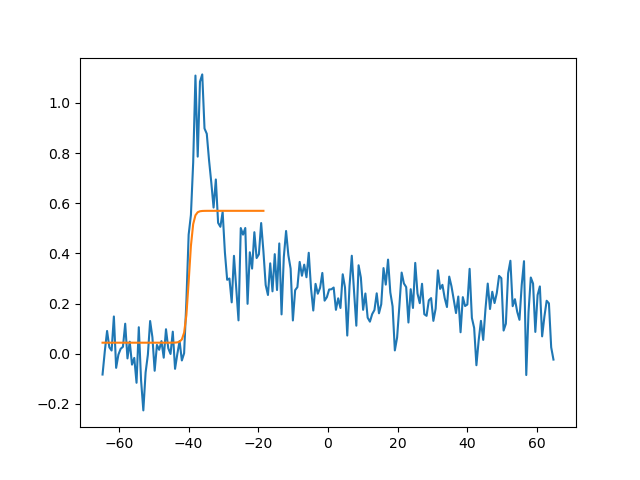

In [ ]:
plt.figure()
plt.plot(x, y_noisy)
fit_profile = sigmoid3(x[indeces], *p_fit)
plt.plot(x[indeces], fit_profile)
plt.show()

In [ ]:
print("Distal faloff:", round(p_fit[2], 2))

Distal faloff: -39.89


## Spline noise

In [ ]:
from scipy import interpolate

In [ ]:
s = interpolate.UnivariateSpline(x, y_noisy, s=1.2)
# xnew = np.arange(x[0],x[maxpeak_index+20], 0.1)
# # ynew = interpolate.splev(xnew, tck, der=0)
yspline = s(x)

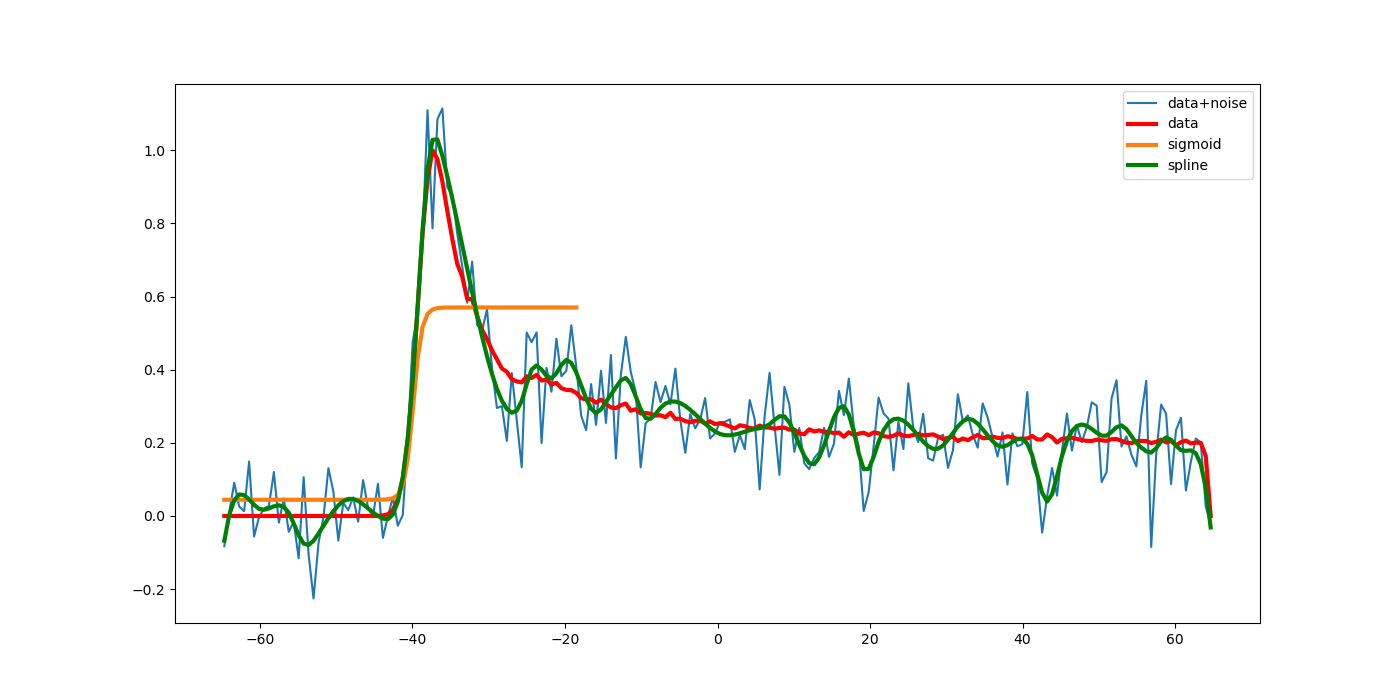

In [ ]:
plt.figure(figsize=(14,7))
plt.plot(x, y_noisy, label="data+noise")
plt.plot(x, y, label="data", lw=3, c="r")
# plt.scatter(x[peaks], reco_sm[peaks], c="r")
plt.plot(x[indeces], fit_profile, c="tab:orange", label="sigmoid", lw=3)
plt.plot(x, yspline, c="g", label="spline", lw=3)
plt.legend()
plt.show()
# plt.scatter(x[minima], reco_sm[minima], c="g")

In [ ]:
from scipy.optimize import root

In [ ]:
xmax = x[yspline.argmax()]
ymax = yspline.max()
ymin = yspline[:yspline.argmax()].mean()
# ymin = 0
ymin = np.median(yspline[:yspline.argmax()])
y_50proc = np.mean([ymin, ymax])

In [ ]:
f = interpolate.UnivariateSpline(x, y_noisy - y_50proc, s=1.2)

In [ ]:
# roots = f.roots()
# distal = roots[roots < x[y.argmax()]][0]
# print("Spline distal:", round(distal, 2))
print("Spline distal:", round(root(lambda x: s(x) - y_50proc, x[y.argmax()])["x"][0], 2))

Spline distal: -39.46


## Median filter

In [ ]:
from scipy.ndimage import median_filter

In [ ]:
y_med = median_filter(y_noisy, size=3)
# xnew = np.arange(x[0],x[maxpeak_index+20], 0.1)
# # ynew = interpolate.splev(xnew, tck, der=0)
# ynew = s(xnew)

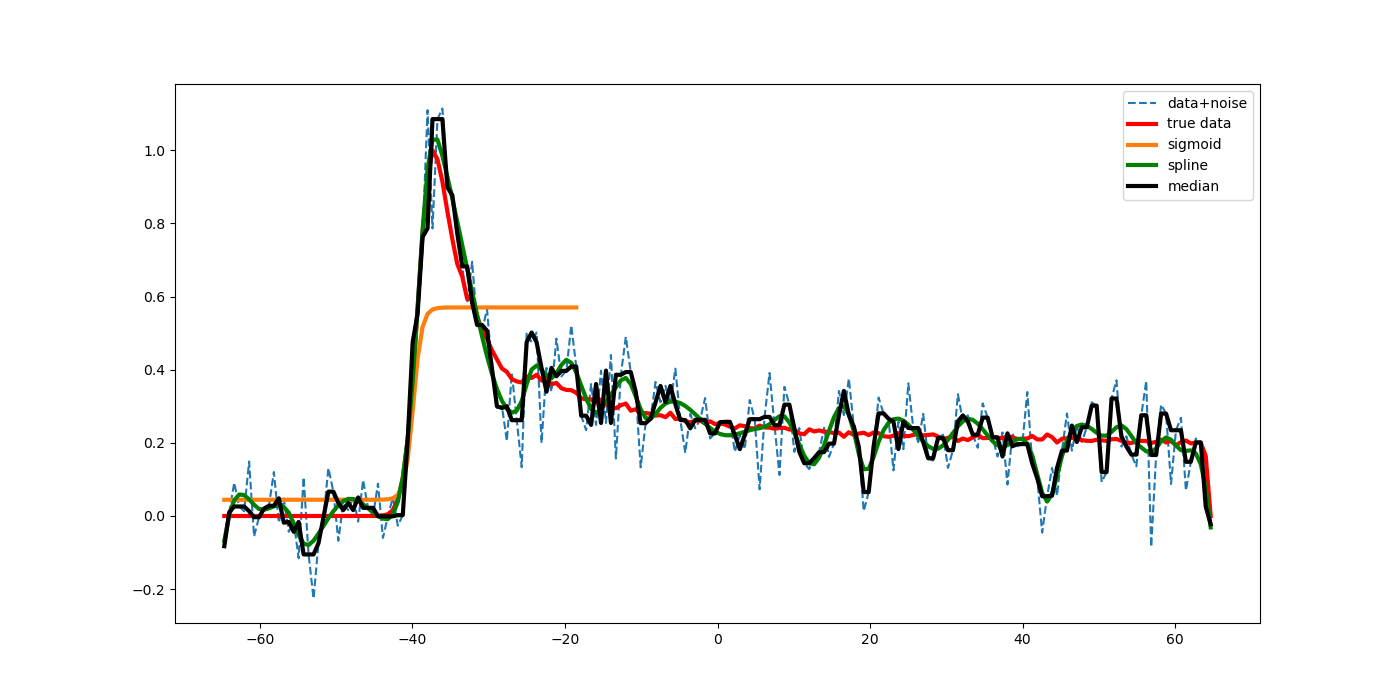

In [ ]:
plt.figure(figsize=(14,7))
plt.plot(x, y_noisy, label="data+noise", ls="dashed")
plt.plot(x, y, label="true data", lw=3, c="r")
# plt.scatter(x[peaks], reco_sm[peaks], c="r")
plt.plot(x[indeces], fit_profile, c="tab:orange", label="sigmoid", lw=3)
plt.plot(x, yspline, c="g", label="spline", lw=3)
plt.plot(x, y_med, c="k", label="median", lw=3)
plt.legend()
plt.show()

In [ ]:
xmax = x[y_med.argmax()]
ymax = y_med.max()
ymin = y_med[:y_med.argmax()].mean()
# ymin = 0
ymin = np.median(y_med[:y_med.argmax()])
y_50proc = np.mean([ymin, ymax])

In [ ]:
print("Median distal:", round(x[np.abs(y_med - y_50proc)[:y_med.argmax()].argsort()[0]], 2))

Median distal: -39.32


In [ ]:
f = interpolate.UnivariateSpline(x, y_med - y_50proc, s=0)

In [ ]:
roots = f.roots()
distal = roots[roots < x[y_med.argmax()]][0]
print("Median + interpolate distal:", round(distal, 2))

Median + interpolate distal: -39.34
